# Waymo: max required deceleration distribution 

- Box plot
    - Total
    - Merge
    - Cross 
- Distribution plot
    - Total
    - Merge
    - Cross 

In [1]:
import pickle
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# import scienceplots
from tqdm import tqdm
from shapely import LineString, Point
from seaborn import displot, histplot, relplot, boxplot
plt.style.use(['seaborn-v0_8-paper'])
# plt.style.use(['ieee', 'notebook'])

from scipy import stats
from waymo_devkit.conflict import Conflict

In [2]:
with open('./pkl/conflict_pet15s.pkl', 'rb') as file:
    conflict_list_from_pickle = pickle.load(file)
print(f"#Conflicts: {len(conflict_list_from_pickle)}")

conflict_list = list()
for c in conflict_list_from_pickle:
    conflict_list.append(
        Conflict(
            leader_id=c['leader_id'],
            leader_index=c['leader_index'],
            leader_states=c['leader_states'],
            leader_time_at_conflict=c['leader_time_at_conflict'],
            follower_id=c['follower_id'],
            follower_index=c['follower_index'],
            follower_states=c['follower_states'],
            follower_time_at_conflict=c['follower_time_at_conflict'],
            PET=c['PET'],
            conflict_type=c['conflict_type'],
            leader_is_av=c['leader_is_av'],
            follower_is_av=c['follower_is_av'],
            center=c['center'],
            radius=c['radius'],
    ))

#Conflicts: 889


In [3]:
"""
Construct a dataframe with the following columns:
- Conflict type
- Vehicle order
- PET
- maxREQDEC
"""
conflict_cols_in_df = [
    "Conflict type",
    "Vehicle order",
    "PET",
    "maxREQDEC"
]

# generate each rows in the dataframe
conflict_rows_in_df = list()
for index, conflict in tqdm(enumerate(conflict_list)):

    leader_type = "AV" if conflict.leader_is_av else "HV"
    follower_type = "AV" if conflict.follower_is_av else "HV" 
    conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
    conflict_rows_in_df.append([
        conflict_type,
        leader_type+"-"+follower_type,
        conflict.PET,
        conflict.max_req_deceleration,
    ])
conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

# Post-process
PET_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]

# display info
conflict_df.info()

889it [00:00, 120281.81it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 864 entries, 0 to 888
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  864 non-null    object 
 1   Vehicle order  864 non-null    object 
 2   PET            864 non-null    float64
 3   maxREQDEC      842 non-null    float64
dtypes: float64(2), object(2)
memory usage: 33.8+ KB


In [4]:
# Post-process: remove maxREQDEC greater than 10s
maxREQDEC_THRESHOLD = 3
conflict_df = conflict_df[conflict_df["maxREQDEC"] <= maxREQDEC_THRESHOLD]

# display info
conflict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836 entries, 1 to 888
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  836 non-null    object 
 1   Vehicle order  836 non-null    object 
 2   PET            836 non-null    float64
 3   maxREQDEC      836 non-null    float64
dtypes: float64(2), object(2)
memory usage: 32.7+ KB


In [5]:
conflict_df["Vehicle order"].value_counts()

HV-HV    365
AV-HV    283
HV-AV    188
Name: Vehicle order, dtype: int64

In [6]:
conflict_df.groupby(["Conflict type", "Vehicle order"])['maxREQDEC'].mean()

Conflict type  Vehicle order
Cross          AV-HV            0.693458
               HV-AV            0.387622
               HV-HV            0.525769
Merge          AV-HV            0.892431
               HV-AV            0.377149
               HV-HV            0.584221
Name: maxREQDEC, dtype: float64

In [7]:
conflict_df.groupby(["Conflict type", "Vehicle order"])['maxREQDEC'].std()

Conflict type  Vehicle order
Cross          AV-HV            0.472259
               HV-AV            0.284138
               HV-HV            0.465143
Merge          AV-HV            0.431050
               HV-AV            0.176771
               HV-HV            0.412764
Name: maxREQDEC, dtype: float64

In [8]:
HVHV = conflict_df[conflict_df["Vehicle order"] == "HV-HV"]
AVHV = conflict_df[conflict_df["Vehicle order"] == "AV-HV"]
HVAV = conflict_df[conflict_df["Vehicle order"] == "HV-AV"]

cross_df = conflict_df[conflict_df["Conflict type"] == "Cross"]
merge_df = conflict_df[conflict_df["Conflict type"] == "Merge"]

HVHV_cross = cross_df[cross_df["Vehicle order"] == "HV-HV"]
AVHV_cross = cross_df[cross_df["Vehicle order"] == "AV-HV"]
HVAV_cross = cross_df[cross_df["Vehicle order"] == "HV-AV"]

HVHV_merge = merge_df[merge_df["Vehicle order"] == "HV-HV"]
AVHV_merge = merge_df[merge_df["Vehicle order"] == "AV-HV"]
HVAV_merge = merge_df[merge_df["Vehicle order"] == "HV-AV"]

## ANOVA

In [10]:
stats.f_oneway(HVHV_merge.maxREQDEC, HVAV_merge.maxREQDEC, AVHV_merge.maxREQDEC)

F_onewayResult(statistic=36.043696627728586, pvalue=1.2849315739615066e-14)

In [11]:
stats.f_oneway(HVHV_cross.maxREQDEC, HVAV_cross.maxREQDEC, AVHV_cross.maxREQDEC)

F_onewayResult(statistic=18.546288386910025, pvalue=1.59330089638987e-08)

## T-test

cross

In [10]:
stats.ttest_ind(HVHV_cross.maxREQDEC, HVAV_cross.maxREQDEC)

Ttest_indResult(statistic=3.225327474621418, pvalue=0.0013593685308114494)

In [11]:
stats.ttest_ind(HVHV_cross.maxREQDEC, AVHV_cross.maxREQDEC)

Ttest_indResult(statistic=-3.5133455635232247, pvalue=0.0004909071953155817)

In [12]:
stats.ttest_ind(HVAV_cross.maxREQDEC, AVHV_cross.maxREQDEC)

Ttest_indResult(statistic=-6.636399945790546, pvalue=1.5921838715077572e-10)

merge

In [13]:
stats.ttest_ind(HVHV_merge.maxREQDEC, HVAV_merge.maxREQDEC)

Ttest_indResult(statistic=3.2886795316815296, pvalue=0.0012731296967855832)

In [14]:
stats.ttest_ind(HVHV_merge.maxREQDEC, AVHV_cross.maxREQDEC)

Ttest_indResult(statistic=-1.8485612401034872, pvalue=0.06574104753778981)

In [15]:
stats.ttest_ind(HVAV_merge.maxREQDEC, AVHV_cross.maxREQDEC)

Ttest_indResult(statistic=-4.487019329956374, pvalue=1.2360328473267937e-05)

## Mann-Whitney U Test

cross

In [16]:
stats.mannwhitneyu(
    x=HVHV_cross.maxREQDEC, 
    y=HVAV_cross.maxREQDEC,
    alternative='two-sided'
).pvalue # pvalue=0.0496199776397865

0.0496199776397865

In [17]:
stats.mannwhitneyu(
    x=HVHV_cross.maxREQDEC, 
    y=AVHV_cross.maxREQDEC,
    alternative='two-sided'
).pvalue

0.0001520655039329194

In [18]:
stats.mannwhitneyu(
    x=HVAV_cross.maxREQDEC, 
    y=AVHV_cross.maxREQDEC,
    alternative='two-sided'
).pvalue

1.7951941912740878e-08

merge

In [19]:
stats.mannwhitneyu(
    x=HVHV_merge.maxREQDEC, 
    y=HVAV_merge.maxREQDEC,
    alternative='two-sided'
) # 0.009895484856327677

MannwhitneyuResult(statistic=2828.0, pvalue=0.009895484856327677)

In [20]:
stats.mannwhitneyu(
    x=HVHV_merge.maxREQDEC, 
    y=AVHV_merge.maxREQDEC,
    alternative='two-sided'
) # pvalue=2.3435277652005332e-08

MannwhitneyuResult(statistic=3606.0, pvalue=2.3435277652005332e-08)

In [22]:
stats.mannwhitneyu(
    x=HVAV_merge.maxREQDEC, 
    y=AVHV_merge.maxREQDEC,
    alternative='two-sided'
) # pvalue=1.0299318015827832e-13

MannwhitneyuResult(statistic=850.0, pvalue=1.0299318015827832e-13)

## Boxplots

### Merge

In [ ]:
conflictType = "Merge"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

g = boxplot(
    data=conflict_df[conflict_df["Conflict type"] == conflictType],
    y="maxREQDEC",
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    palette=palette,
    gap=.5,
    legend=True,
)

g.set_xlabel("Vehicle order")
g.set_ylabel("Max required deceleration")

plt.title(f"Max req dec distribution [{conflictType}] (Waymo)")
plt.savefig(f"./outputs/plots/waymo_boxplot_maxREQDEC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()
conflict_df[conflict_df["Conflict type"] == conflictType].to_csv("./waymo_max_req_dec_merge.csv")

### Cross

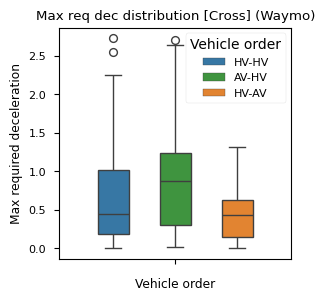

In [49]:
conflictType = "Cross"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

g = boxplot(
    data=conflict_df[conflict_df["Conflict type"] == conflictType],
    y="maxREQDEC",
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    palette=palette,
    gap=.5,
    legend=True,
)

g.set_xlabel("Vehicle order")
g.set_ylabel("Max required deceleration")

plt.title(f"Max req dec distribution [{conflictType}] (Waymo)")
plt.savefig(f"./outputs/plots/waymo_boxplot_maxREQDEC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()
conflict_df[conflict_df["Conflict type"] == conflictType].to_csv("./waymo_max_req_dec_merge.csv")

## Distplots

### All

<Figure size 300x300 with 0 Axes>

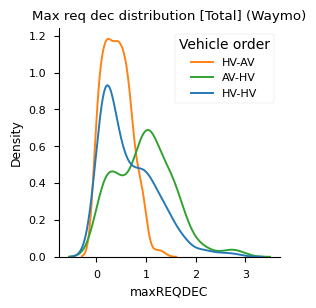

In [38]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}

HVHV_COLOR = '#257ab6'
HVAV_COLOR = '#31a231'
AVHV_COLOR = '#ff8214'

FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
conflictType = "Total"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df,
    x="maxREQDEC", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

# plt.xlim([0, maxREQDEC_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"Max req dec distribution [{conflictType}] (Waymo)")
plt.savefig(f"./outputs/plots/waymo_distribution_maxREQDEC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()

### Merge

<Figure size 300x300 with 0 Axes>

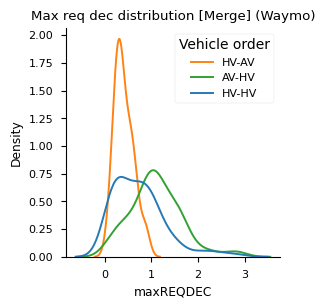

In [16]:
conflictType = "Merge"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df[conflict_df["Conflict type"]==conflictType],
    x="maxREQDEC", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

# plt.xlim([0, maxREQDEC_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"Max req dec distribution [{conflictType}] (Waymo)")
plt.savefig(f"./outputs/plots/waymo_distribution_maxREQDEC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()

### Cross

<Figure size 300x300 with 0 Axes>

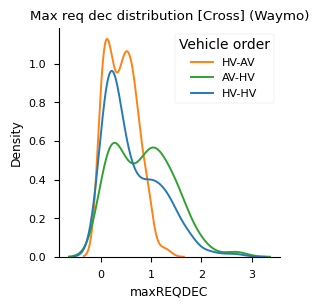

In [17]:
conflictType = "Cross"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df[conflict_df["Conflict type"]==conflictType],
    x="maxREQDEC", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

# plt.xlim([0, maxREQDEC_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"Max req dec distribution [{conflictType}] (Waymo)")
plt.savefig(f"./outputs/plots/waymo_distribution_maxREQDEC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()